In [1]:
import pandas as pd

In [ ]:
!pip install econml

# Casual Analysis 1 and 2, Basic


## no.1 why we need to do propensity matching score?

answers : 


1.   to reduce to potential effects of confounders variables
2.   to make dataset more balanced



## no 2. why double ML is better than double selection?

answers:
the steps for  conduction double selection are:


1.  Estimates the equation of X (confounding variabels) on Y (response)
2.  Estimates the equation of X on D (treatment variable)
3.  Estimates the equation of X and D on Y, by including the X variables on first and second equations. In other words, the dropped X variable in equation 1 can be included if it can also impact on D.

The problem with this is we might include X that does have an impact on D, but does not actually have an impact on Y. This can have an impact on estimation of average treatment (D) effect.  

We solve this problem using Double Machine Learning method. in this method, in step 3 we get dont use X variables to predict Y, instead we use only use our treatment variables to predict Y. but we must make sure we use their residuals, for both treatment and Y variables, not the original data. To get residuals treatment and Y variables, we need: 


1.   Estimates the Y using X variables, get the estimated Y
2.   Estimates the D using X variables, get the estimated D
3.   Residual D = D - estimated D
4.   Residual Y = Y - estimated Y
5.   Estimates the average effect of Residual D on Residual Y

we use this estimation of average effect of residual D to measure the average effect of treatment variables on response. 




reference :


1.   https://www.r-bloggers.com/2017/05/problems-of-causal-inference-after-selecting-of-controls/
2.   https://www.r-bloggers.com/2020/09/lasso-and-the-methods-of-causality/
3. http://www2.stat.duke.edu/~fl35/teaching/640/Chapter4_MachineLearning.pdf
4. https://madina-k.github.io/dse_mk2021/tutorial_dml.html




## no 3. When to use ATE, CATE, and LATE for analysing treatment effect?

answers:


*   WE use ATE when we want to see the average effect of treatment on a sample
*   We use CATE when we want to see the average effect of treatment on sample on certain condition. In other words, we want to see the average effect of treatment on the subgroup of the sample. For example, we may suspect that men and women respond differently to treatment.hence , we can estimate CATE for group men only and women only. 

* we use LATE when we want to see the average treatment effect only for a subgroup of the sample that really follow their assignment as a treated or a control. in other words, it capture the effect on treatment group who actually receive the treatment, not just those people that were put into the treatment group. It does not capture effects of the treatment among everyone in the experimental sample, which in this case we use(ATE).




reference:


1.   https://egap.org/resource/10-types-of-treatment-effect-you-should-know-about/
2.   https://egap.org/resource/10-things-to-know-about-the-local-average-treatment-effect/



# Casual Analysis 1 and 2 : advanced

#no 1. select covariates, and treatment variable


*   Treatment : intervention
*   Response : achievement_score
*   Covariates : ['success_expect',
       'ethnicity', 'gender', 'frst_in_family', 'school_urbanicity',
       'school_mindset', 'school_achievement', 'school_ethnic_minority',
       'school_poverty', 'school_size']

Reason choosing these covariates:



1.   all these variables do not have a high correlation coefficient, meaning it is highly likely we wont have multicollinearity problem if we use all of them
2.  the more we capture the effect of confounding variables , our estimation of the average effect of treatment will be more robust




# no2. Model Selections

for this dataset,we use DML. Reasons:


1.   There is [paper](https://www.sciencedirect.com/science/article/pii/S0360131521000671?casa_token=Kbfvn-CfHr0AAAAA:WfVvbdeB9i2KAo_HCg2jFmUOJUjbTMvHRFK4HHhhUlr-ahy4UcyKRzVARvaF-oxhH_gW9vKR) with a similar dataset, and it use DML to find the causal effect
2.   Treatment is discrete
3. confounders are observed in the dataset



# no 3. Analysis

## import packages

In [154]:
import pandas as pd
import numpy as np
# scikit learn
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
# import train and test split method from scikit-learn
from sklearn.model_selection import train_test_split

# econml
from econml.dml import DML
from econml.metalearners import TLearner, SLearner, XLearner

## import dataset

In [88]:
df = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/learning_mindset/learning_mindset.csv")

In [89]:
df_school = df.drop(columns = ["schoolid"])

## checking correlation

In [206]:
df_corr = df_school.corr().stack().reset_index()
df_corr.columns = ["var1","var2","val"]
df_corr["val"]= np.abs(df_corr["val"])
df_corr = df_corr.sort_values(by=["val"], ascending = False)
df_corr.loc[df_corr["var1"]!=df_corr["var2"]].head()

,var1,var2,val
92,school_mindset,school_achievement,0.573798
103,school_achievement,school_mindset,0.573798
139,school_size,school_mindset,0.492287
95,school_mindset,school_size,0.492287
116,school_ethnic_minority,school_achievement,0.478682


all variabels do not have a high correlation score with each other

## train test split

In [96]:
test_index = df_school.sample(frac=0.3).index
ice_cream_test = df_school.iloc[test_index]
ice_cream_train = df_school.iloc[pd.Index(set(df_school.index).difference(set(test_index)))]

In [180]:
ice_cream_test = df_school.iloc[test_index]

In [116]:
ice_cream_train = df_school.iloc[pd.Index(set(df_school.index).difference(set(test_index)))]

In [139]:
ice_cream_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7274 entries, 2 to 10390
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   intervention            7274 non-null   int64  
 1   achievement_score       7274 non-null   float64
 2   success_expect          7274 non-null   int64  
 3   ethnicity               7274 non-null   int64  
 4   gender                  7274 non-null   int64  
 5   frst_in_family          7274 non-null   int64  
 6   school_urbanicity       7274 non-null   int64  
 7   school_mindset          7274 non-null   float64
 8   school_achievement      7274 non-null   float64
 9   school_ethnic_minority  7274 non-null   float64
 10  school_poverty          7274 non-null   float64
 11  school_size             7274 non-null   float64
dtypes: float64(6), int64(6)
memory usage: 996.8 KB


## modelling with double machine learning method

In [166]:
# set response
dv = ice_cream_train["achievement_score"]
# set covariates
iv = ice_cream_train[['success_expect',
       'ethnicity', 'gender', 'frst_in_family', 'school_urbanicity',
       'school_mindset', 'school_achievement', 'school_ethnic_minority',
       'school_poverty', 'school_size']]
# set treatment variabel
t = ice_cream_train["intervention"]

In [181]:
#set data for prediction
iv_test = ice_cream_test[['success_expect',
       'ethnicity', 'gender', 'frst_in_family', 'school_urbanicity',
       'school_mindset', 'school_achievement', 'school_ethnic_minority',
       'school_poverty', 'school_size']]

In [172]:
# define DML Object
dml_est = DML(
    model_y = GradientBoostingRegressor(n_estimators=100, random_state = 1000),
    model_t = GradientBoostingRegressor(n_estimators=100, random_state = 1000),
    model_final = LinearRegression(fit_intercept=False),
    random_state = 1000
)

In [176]:
# fit estimator to train data
np.random.seed(1000)
dml_est.fit(dv, T = t, X = iv, inference="bootstrap")

In [177]:
dml_est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
success_expect,0.029,0.019,1.535,0.06,-0.009,0.066
ethnicity,0.0,0.006,0.056,0.48,-0.012,0.009
gender,0.014,0.042,0.328,0.48,-0.071,0.098
frst_in_family,-0.007,0.044,-0.166,0.35,-0.109,0.055
school_urbanicity,0.006,0.018,0.3,0.32,-0.023,0.044
school_mindset,-0.033,0.029,-1.154,0.18,-0.097,0.019
school_achievement,0.01,0.034,0.297,0.3,-0.041,0.084
school_ethnic_minority,-0.008,0.026,-0.303,0.2,-0.066,0.035
school_poverty,0.038,0.026,1.492,0.03,-0.002,0.098
school_size,0.022,0.028,0.789,0.24,-0.03,0.078


Intepretation:  all covariates have effect, eventough only school_poverty has signicant effect (p_value < 0.05) in impacting achievement score

In [182]:
# Get treatment effect and its confidence interval
te_pred = dml_est.effect(iv_test)

In [183]:
# Measure treatment effect
np.mean(te_pred)

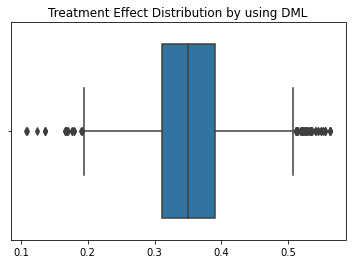

In [185]:
import seaborn as sns
# check treatment effect distribution
sns.boxplot(x = te_pred).set_title("Treatment Effect Distribution by using DML");

## Conclusions

Because the ATE is positive, we can interpret that if student schooled about “growth mindset", their achievement score should be increased

# Github link